In [1]:
from astropy.table import Table
import numpy as np
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import stats
from functions import *
import pickle
from astropy.io import fits
from scipy.optimize import curve_fit
from scipy.stats import skewnorm, norm
from scipy import stats
from scipy.optimize import minimize
from scipy import optimize
np.set_printoptions(threshold=sys.maxsize)

In [2]:
matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=18)
matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

In [3]:
# data_old = Table.read('data_flags_updated_Oct8.dat', format = 'ascii')
data = Table.read('data_flags_updated_Nov1.dat', format = 'ascii')
catalog =data
ra_boolean = np.logical_and(catalog['ra'] > 110, catalog['ra'] < 270)
catalog_north = catalog[ra_boolean]
strip_boolean = np.logical_and.reduce([catalog_north['ra'] > 250, 
                                       catalog_north['ra'] < 269, 
                                       catalog_north['dec'] > 51, 
                                       catalog_north['dec'] < 67])
catalog_main = catalog_north[~strip_boolean]
data = catalog_main#[catalog_main['redshift']< 0.1026]

In [4]:
# ra,dec,z
ra = np.array(data['ra'])
dec = np.array(data['dec'])
z = np.array(data['redshift'])

In [5]:
#stellar mass
Mstar = np.array(data['Mstar'])
# color
u_r = np.array(data['u_r'])
# u_r = u_r[np.logical_not(np.isnan(u_r))] 

g_r = np.array(data['g_r'])

# absolute magnitude
rabsmag = np.array(data['rabsmag'])

#star formation rate and specific SPR
SFR  = np.array(data['SFR'])

sSFR = np.array(data['sSFR'])


In [6]:
#classification V^2

wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder

wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

# len(wall_v2)+len(void_v2)+len(edge_v2)+len(out_v2),len(wall_vf)+len(void_vf)+len(edge_vf)+len(out_vf), len(data) #check

In [13]:
def char(char_, bins_, title='galaxy property', label='x-label', voidfinder=False,x=None,y=None):
    '''
    Plots a histogram for a galaxy charachterstic for wall and void galaxies
    
    arguments:
    
    char_ : (numpy array) charachteristic of galaxy desired for plotting
    bins_ : (numpy linear space) histogram bins
    voidfinder : (bool) True if the classification comes from the voidfinder algorithm, False if it comes from V^2
    x: x coordinate of the location of the algorithm's name 
    y: y coordinate of the location of the algorithm's name
    '''
    if voidfinder == True:
        char_wall = char_[wall_vf]
        char_void = char_[void_vf]
#         char_edge = char_[edge_vf]
#         char_out = char_[out_vf]
        x_vf=x
        y_vf=y
    else:
        char_wall = char_[wall_v2]
        char_void = char_[void_v2]
#         char_edge = char_[edge_v2]
#         char_out = char_[out_v2]
        x_v2=x
        y_v2=y
    fig, ax = plt.subplots(figsize=(12, 8))
    
    ax.tick_params(labelsize=27)
    
    counts_wall, bins_wall = np.histogram(char_wall, bins= bins_)
    counts_void, bins_void = np.histogram(char_void, bins= bins_)
    
#     counts_edge, bins_edge = np.histogram(char_edge, bins= bins_)
#     counts_out, bins_out = np.histogram(char_out, bins= bins_)
    
    counts_all, bins_all = np.histogram(char_[data['redshift']< 0.1026], bins= bins_)
    
    
    counts_wall,counts_void = np.array(counts_wall)/len(char_wall), np.array(counts_void)/len(char_void)
#     counts_edge, counts_out = np.array(counts_edge)/len(char_edge), np.array(counts_out)/len(char_out)
    counts_all = np.array(counts_all)/len(char_[data['redshift']< 0.1026])

    color_wall='blue'
    color_void='green'
    if voidfinder ==True:
        color_wall='black'
        color_void='red'
        
    ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', fill = True,facecolor='gainsboro',edgecolor='gainsboro', histtype = 'step')


    ax.hist(bins_wall[:-1], bins=bins_wall, weights=counts_wall, label = 'Wall' , color=color_wall, histtype='step',linestyle=('dashed'))
    ax.hist(bins_void[:-1], bins=bins_void, weights=counts_void ,label = 'Void', color = color_void,histtype='step')
    
#     ax.hist(bins_edge[:-1], bins=bins_edge, weights=counts_edge ,label = 'Edge', color = 'green',histtype='step')
#     ax.hist(bins_out[:-1], bins=bins_out, weights=counts_out ,label = 'Out', color = 'purple',histtype='step')

#     ax.hist(bins_all[:-1], bins=bins_all, weights=counts_all,  label = 'All', color = 'gray',alpha = 0.2)
    
#     if (voidfinder == True) & (x!= None):
#         ax.text(x_vf, y_vf, "VoidFinder", fontsize=20)
#     if (voidfinder == False) & (x!= None):
#         ax.text(x_v2, y_v2, r'\boldmath$V^{2}$', fontsize=20)
    
    ax.legend(fontsize=23)
#     plt.title(title, fontsize=18)
    ax.set_xlabel(label, fontsize=29)
    ax.set_ylabel(r"Fraction of galaxies",fontsize=29)
    
    if label == 'Absolute Magnitude' or label == 'Absolute Magnitude - NSA':
        ax.set_xlim(-12, -24) 
    
    plt.savefig('figures/'+title+".eps", format='eps')
    plt.show()
    
    


### Star mass

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


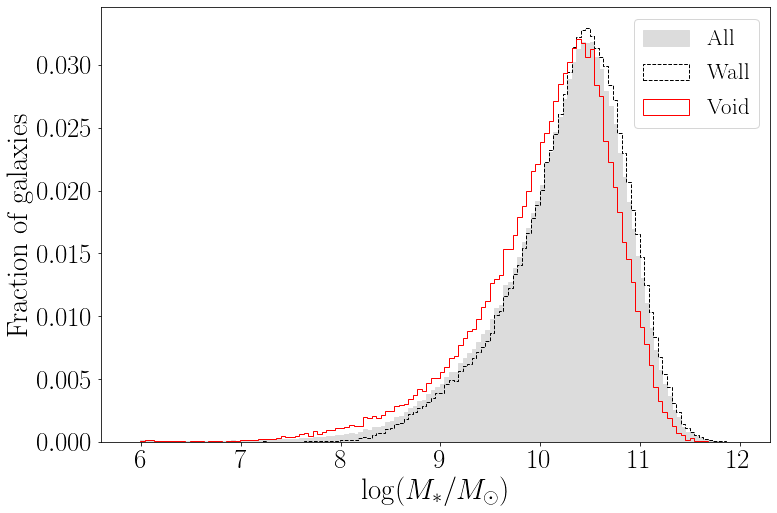

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


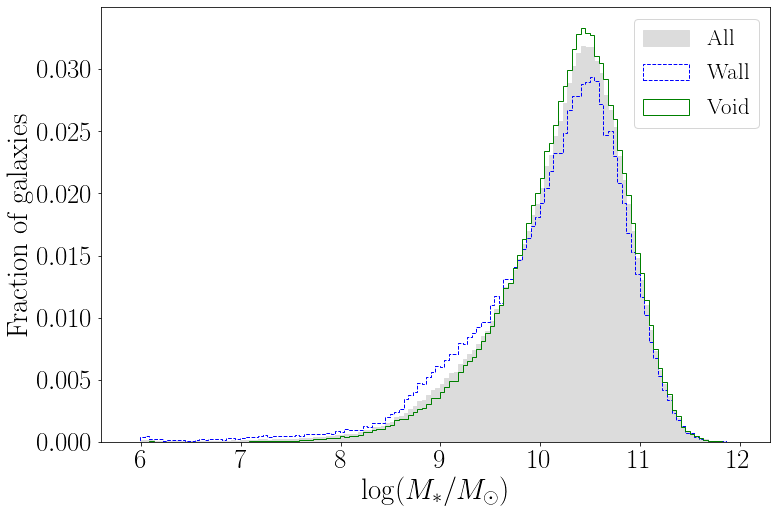

In [15]:
char(Mstar,np.linspace(5.9,12, 135),r'Star_Mass_Voidfinder',r'$\log(M_*/M_\odot)$', voidfinder = True,x=6,y=0.025)
char(Mstar,np.linspace(5.9,12, 135),r'Star_Mass_V2',r'$\log(M_*/M_\odot)$',x=6,y=00.025)


### Color u_r

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


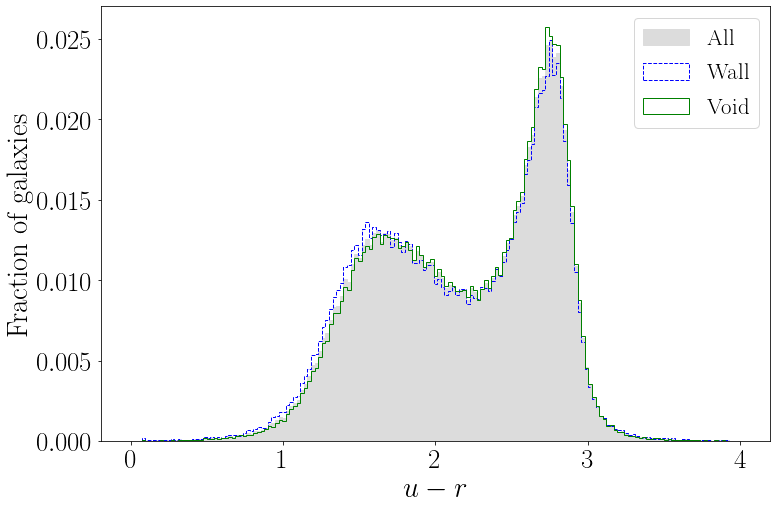

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


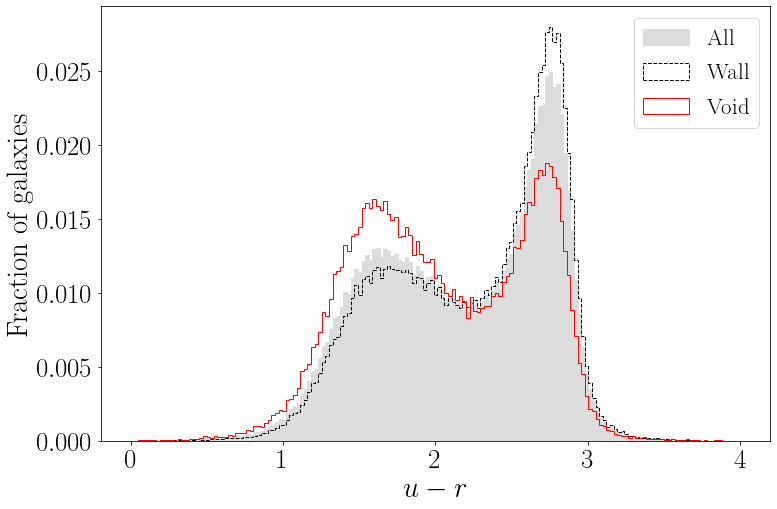

In [16]:
char(u_r,np.linspace(0,4, 170),'Color_u_r_V2',r'$u-r$',x=0.2,y=0.016)
char(u_r,np.linspace(0,4, 170),'Color_u_r_Voidfinder',r'$u-r$', voidfinder = True,x=0.2,y=0.016)



### Color g_r 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


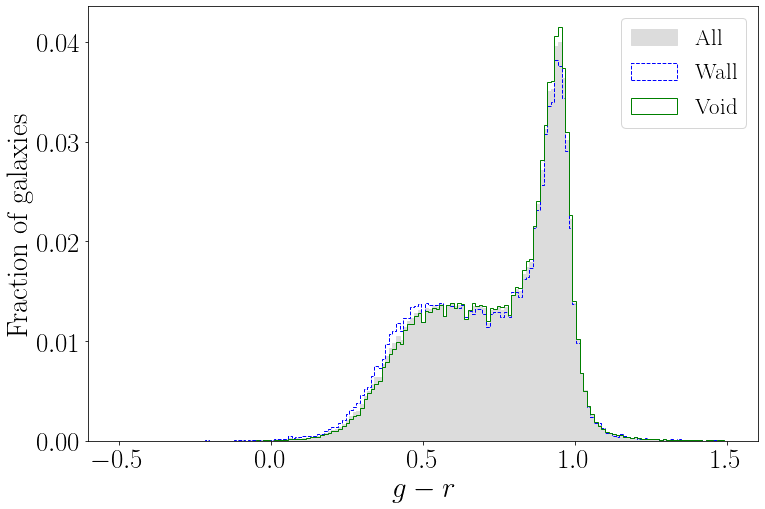

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


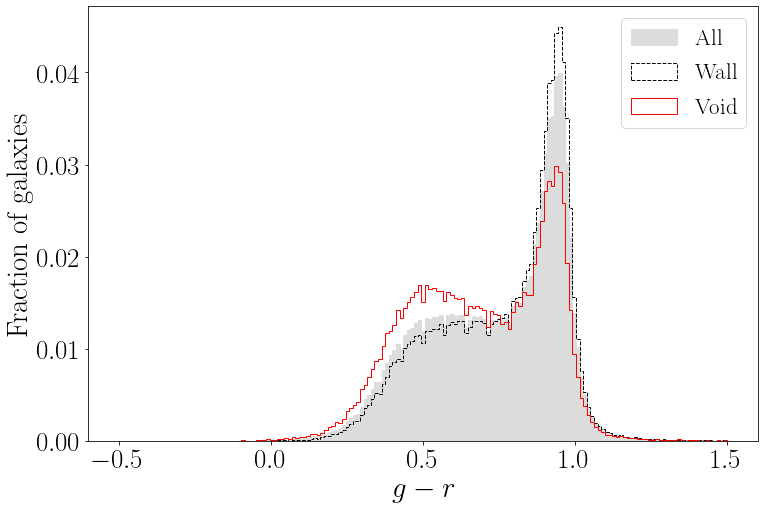

In [17]:
char(g_r,np.linspace(-0.5,1.5, 170),'Color_g_r_V2',r'$g-r$',x=-0.35,y=0.025)
char(g_r,np.linspace(-0.5,1.5, 170),'Color_g_r_Voidfinder',r'$g-r$', voidfinder = True,x=-0.35,y=0.025)

### Absolute magnitude

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


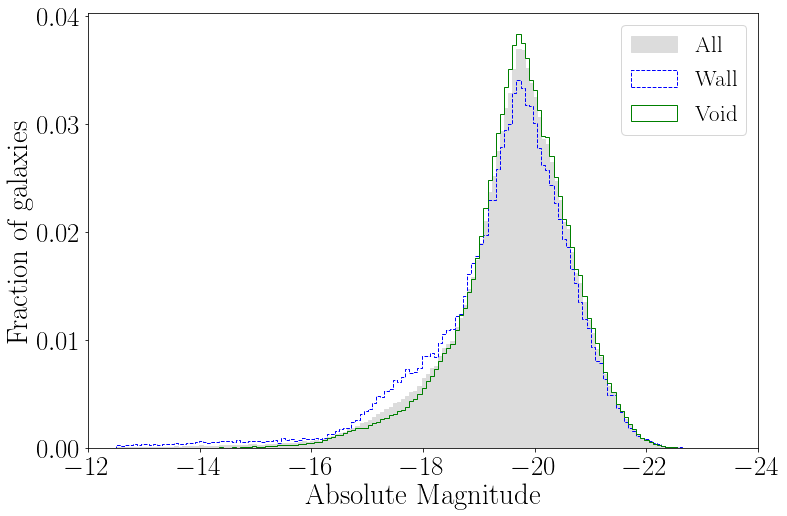

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


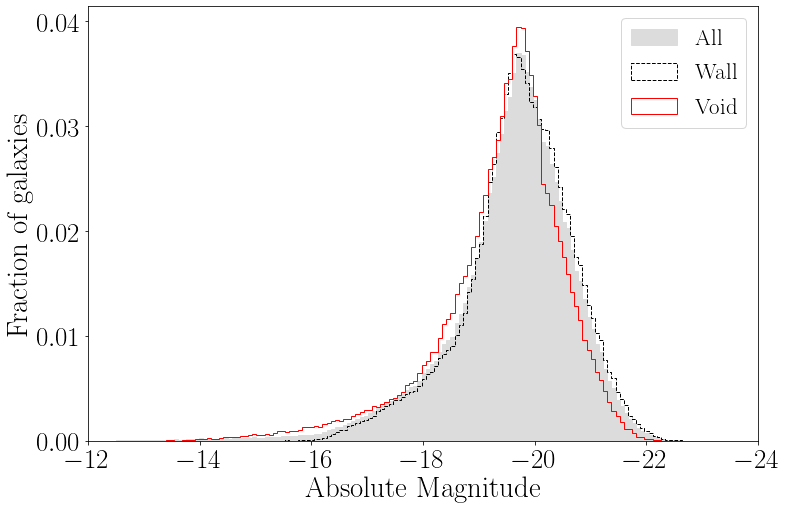

In [18]:
char(rabsmag,np.linspace(-25,-12.5, 170),'Absolute_Magnitude_V2','Absolute Magnitude',x=-13,y=0.023)
char(rabsmag,np.linspace(-25,-12.5, 170),'Absolute_Magnitude_Voidfinder','Absolute Magnitude', voidfinder = True,x=-13,y=0.023)


#### Star Formation Rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


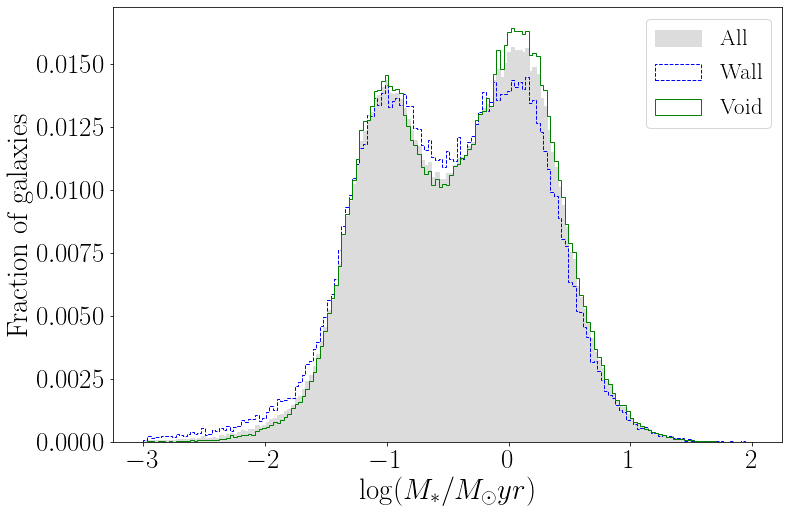

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


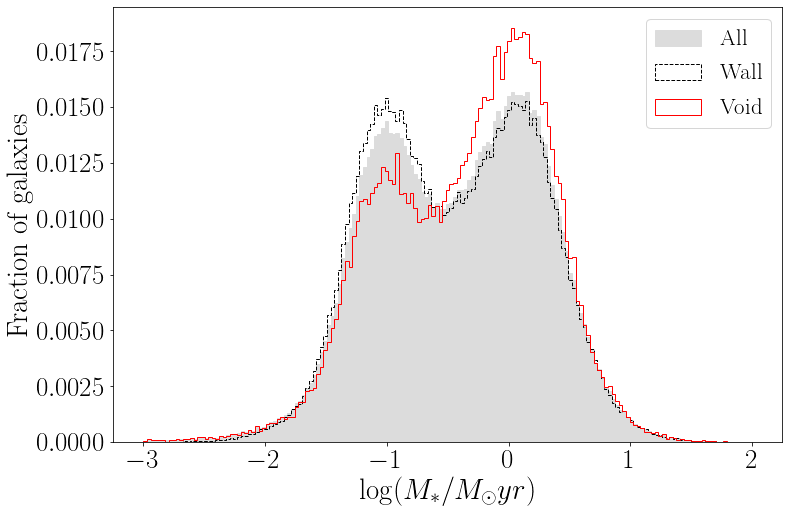

In [19]:
char(SFR,np.linspace(-3,2, 170),'star_formation_rate_V2',r'$\log(M_*/M_\odot yr)$',x=-2.7,y=0.0105)
char(SFR,np.linspace(-3,2, 170),'star_formation_rate_Voidfinder',r'$\log(M_*/M_\odot yr)$', voidfinder = True,x=-2.7,y=0.012)

#### Specific star Formation Rate

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


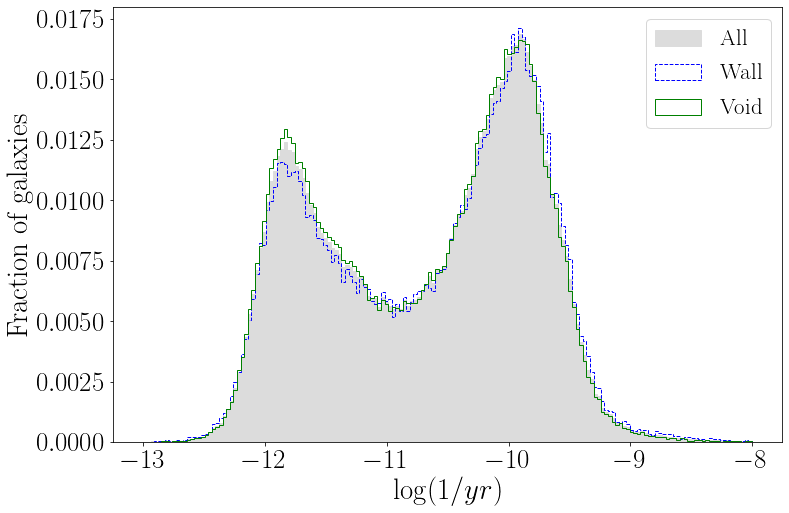

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


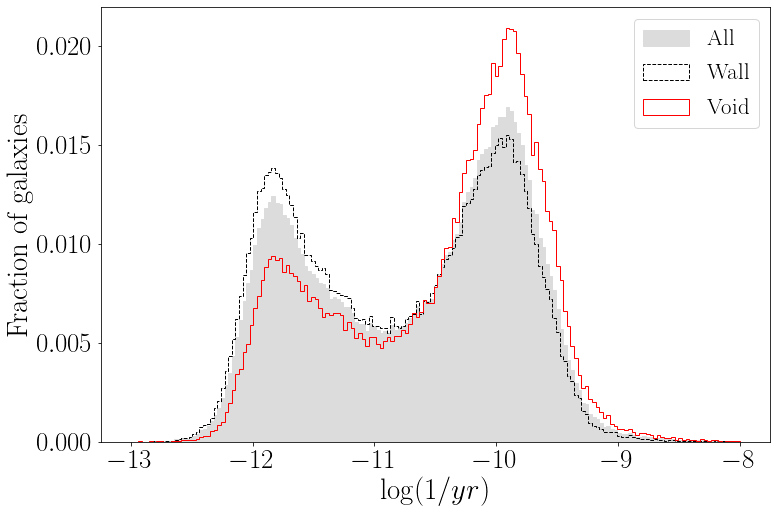

In [20]:
char(sSFR,np.linspace(-13,-8, 170),'specific_star_formation_rate_V2',r'$\log(1/yr)$',x=-12.7,y=0.0105)
char(sSFR,np.linspace(-13,-8, 170),'specific_star_formation_rate_Voidfinder',r'$\log(1/yr)$', voidfinder = True,x=-12.7,y=0.013)

### fit the distributions with skewnormal distributions

In [11]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)
def func_unimodal(x, a, mua, sga, askew):
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) 

In [15]:
# def bin_data(data,bins_,label="label me", plot=False): 

#     n1, edges1 = np.histogram(data, bins=bins_)
#     dn1 = np.sqrt(n1)
#     x = 0.5*(edges1[1:] + edges1[:-1])
        
# #     if plot == True:
# #         plt.errorbar(x, n1, yerr=dn1, fmt='.')        
# #         plt.xlabel(label, fontsize=18)
# #         plt.ylabel('count',fontsize=18) 
# #         plt.title("Binned Data ")
# #         plt.show()
        
#     return  x,n1,dn1 #, popt_void

In [16]:
# o = bin_data(data=rabsmag[wall_v2],bins_=np.linspace(-25,-12.5, 250))
# plt.errorbar(o[0], o[1], yerr=o[2], fmt='.') 
# plt.xlim(-12,-24)
# plt.xlabel("Absolute Magnitude")
# plt.show()

In [17]:
# bin_data_ = bin_data(Mstar[wall_vf],bins_=np.linspace(5.9,12, 135))

In [151]:
# def dist(abs_mag):
#     return ((10)*10**((17.7 - abs_mag)/5))/10**6 # divided by 10**6 to go from pc to Mpc 


In [12]:
# def bin_err(x):  
#     inv_Vmax = 1/(((10)*10**((17.7 - np.array(x))/5))/10**6)**3
#     return np.sqrt(np.sum(inv_Vmax**2))


# def bin_errors(char_,bins_):
    
#     test1=np.digitize(char_, bins=bins_) # gives index of bin where galaxy belongs
    
#     bin_glx_ind=[]  # galaxy indices containes in each absolute magnitude bin
    
#     for i in range(len(bins)):
#         bin_glx_ind.append(np.argwhere(test1==i))
#     bin_glx_ind=np.array(bin_glx_ind)

#     bin_errors=[]
#     for i in range(len(bin_glx_ind)):
#         bin_errors.append(bin_err(char_[bin_glx_ind[i]]))
        
#     bin_errors=np.array(bin_errors)
#     return bin_errors


In [238]:
# test1 = np.digitize(rabsmag[wall_v2], bins=np.linspace(-23,-12.5, 250)) # index of bin to which glx belongs

In [16]:
# k = bin_data(rabsmag[wall_v2],bins_=np.linspace(-23,-12.5, 250),label="label me", plot=False)
# x,poiss_err=k[0],k[2]

In [17]:
# plt.figure(figsize=(8,6))
# plt.scatter(x,poiss_err,s=4, label="Poisson error sqrt(n)")  # from bright to faint, small error to large error
# plt.xlim(-12.5,-23)
# plt.xlabel("abs magnitude wall V2")
# plt.legend()
# plt.show()

In [15]:
# plt.figure(figsize=(8,6))
# plt.scatter(np.linspace(-23,-12.5, 250),bin_errors,s=4, label="sqrt(sum(1/Vmaxi))") # from bright to faint, small error to large error
# plt.xlim(-12.5,-23)
# plt.xlabel("abs magnitude wall V2")
# plt.legend()
# plt.show()

In [18]:
# plt.figure(figsize=(15,8))
# plt.errorbar(bin_data_[0], bin_data_[1], yerr=bin_errors[:-1], fmt='.', alpha=0.5, label="sqrt(sum(1/Vmaxi2))")  
# plt.errorbar(bin_data_[0], bin_data_[1], yerr=poiss_err, fmt='.',alpha=0.5,label= "sqrt(n)")

# plt.xlim(-12.5,-23)
# plt.xlabel("abs magnitude wall V2")
# plt.ylabel("counts")
# plt.legend()
# plt.show()

In [19]:
# plt.figure(figsize=(15,8))
# plt.errorbar(bin_data[0], bin_data[1], yerr=bin_errors[:-1]*100000, fmt='.', alpha=0.5, label="sqrt(sum(1/Vmaxi))")  
# plt.errorbar(bin_data[0], bin_data[1], yerr=poiss_err, fmt='.',alpha=0.5,label= "sqrt(n)")

# plt.xlim(-12.5,-23)
# plt.xlabel("abs magnitude wall V2")
# plt.legend()
# plt.show()

In [20]:
# plt.figure(figsize=(15,8))
# plt.errorbar(bin_data[0], bin_data[1], yerr=bin_errors[:-1]*9000, fmt='.', alpha=0.5, label="sqrt(sum(1/Vmaxi))")  
# plt.errorbar(bin_data[0], bin_data[1], yerr=poiss_err, fmt='.',alpha=0.5,label= "sqrt(n)")

# plt.xlim(-12.5,-23)
# plt.xlabel("abs magnitude wall V2")
# plt.ylabel("counts")
# plt.legend()
# plt.show()

In [10]:
# def bin_data_t(data,bins_,weights_=None,label="label me", plot=False): 

#     n1, edges1 = np.histogram(data, bins=bins_,density=True,weights=weights_)#,density=True)
# #     dn1 = np.sqrt(n1)
#     x = 0.5*(edges1[1:] + edges1[:-1])
        
# #     if plot == True:
# #         plt.errorbar(x, n1, yerr=dn1, fmt='.')        
# #         plt.xlabel(label, fontsize=18)
# #         plt.ylabel('count',fontsize=18) 
# #         plt.title("Binned Data ")
# #         plt.show()
        
#     return  x,n1,edges1,np.sum(n1),np.sqrt(n1)#,dn1 #, popt_void

In [9]:
# fig=plt.figure(figsize=(15,8))
# char,bins, label=rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# # SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"



# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"



# #u_r,np.linspace(0,4, 170), "u-r VoidFinder"


# #rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"


# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"
# #bin_errors

# # Mstar,np.linspace(5.9,12, 135), "Mstar-VoidFinder"


# # rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"

# # u_r,np.linspace(0,4, 170), "u-r VoidFinder"

# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"

# #Mstar,np.linspace(5.9,12, 135), "Mstar-Voidfinder"
# #np.linspace(-3,2, 170)
# t_wall = bin_data_t(data=char[wall_vf],bins_=bins, weights_=1/dist(rabsmag[wall_vf])**3)
# t_void = bin_data_t(data=char[void_vf],bins_=bins, weights_=1/dist(rabsmag[void_vf])**3)

# # yerr_wall=(1/np.log(10))*np.array(bin_errors(char[wall_vf],bins))[:-1]/(t_wall[1])#*t_wall[-1])
# yerr_wall = np.sqrt(t_wall[1])
# yerr_void = np.sqrt(t_void[1])

# # yerr_void=(1/np.log(10))*np.array(bin_errors(char[void_vf],bins))[:-1]/(t_void[1])#*t_wall[-1])

# plt.errorbar(t_void[0], np.log10(t_void[1]),fmt=".", color='red',label="void", yerr=yerr_void)  # /np.sum(error_weight) in each bin , density=True
# plt.errorbar(t_wall[0], np.log10(t_wall[1]),fmt=".",color='black', label="wall",yerr=yerr_wall)  # /np.sum(error_weight) in each bin , density=True
# # plt.yscale("log")
# # plt.ylim(-7,1)

# # plt.xlim(-12,-24)
# plt.ylabel(str(" normalized , weighted, log-ed counts"))
# plt.xlabel(label)
# plt.title(str("weight=1/Vmax, density=True"))
# plt.legend()
# plt.show()

In [13]:
# print("weighted errors, corrected for log and for normalization")

# fig=plt.figure(figsize=(15,8))
# char,bins, label=rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"


# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"


# #rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# # SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"



# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"



# #u_r,np.linspace(0,4, 170), "u-r VoidFinder"


# #rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"


# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"
# #bin_errors

# # Mstar,np.linspace(5.9,12, 135), "Mstar-VoidFinder"


# # rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"

# # u_r,np.linspace(0,4, 170), "u-r VoidFinder"

# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"

# #Mstar,np.linspace(5.9,12, 135), "Mstar-Voidfinder"
# #np.linspace(-3,2, 170)
# t_wall = bin_data_t(data=char[wall_vf],bins_=bins, weights_=1/dist(rabsmag[wall_vf])**3)
# t_void = bin_data_t(data=char[void_vf],bins_=bins, weights_=1/dist(rabsmag[void_vf])**3)

# yerr_wall=(1/np.log(10))*np.array(bin_errors(char[wall_vf],bins))[:-1]/(t_wall[1])#*t_wall[3])

# yerr_void=(1/np.log(10))*np.array(bin_errors(char[void_vf],bins))[:-1]/(t_void[1])#*t_wall[3])

# plt.errorbar(t_void[0], np.log10(t_void[1]),fmt=".", color='red',label="void", yerr=yerr_void)  # /np.sum(error_weight) in each bin , density=True
# plt.errorbar(t_wall[0], np.log10(t_wall[1]),fmt=".",color='black', label="wall",yerr=yerr_wall)  # /np.sum(error_weight) in each bin , density=True
# # plt.yscale("log")
# # plt.ylim(-7,1)

# # plt.plot(t_void[0], lum_fit(t_void[0], *popt), 'r-',

# #          label='fit: Mstar=%5.3f, phi=%5.3f, alpha=%5.3f' % tuple(popt))

# # plt.xlim(-12,-24)
# plt.ylabel(str(" normalized , weighted, log-ed counts"))
# plt.xlabel(label)
# plt.title(str("weight=1/Vmax, density=True"))
# plt.legend()
# plt.show()

### fitting luminosity function

In [14]:
# def lum_fit(M_r,M_star,phi,alpha):
#     return 0.4*np.log(10)*phi*((10**(M_star-M_r))**(alpha+1)) * np.exp(-10**(0.4*(M_star-M_r)))

In [15]:
# plt.scatter(t_void[0],lum_fit(t_void[0], -20,1,-1))
# plt.yscale("log")
# plt.show()

In [16]:
# yaxis = np.log10(t_void[1])[np.log10(t_void[1])!=-np.inf]
# xaxis=t_void[0][np.log10(t_void[1])!=-np.inf]

# popt, pcov = curve_fit(lum_fit, xaxis,yaxis, [-20,1,-1])

# plt.plot(t_void[0], lum_fit(t_void[0], *popt), 'r-',

#          label='fit: Mstar=%5.3f, phi=%5.3f, alpha=%5.3f' % tuple(popt))

# plt.legend()
# plt.show()

# # does not work

In [17]:
# curve_fit(lum_fit, xaxis, yaxis,  [-20,1,-1])

In [18]:
# minimize(lum_fit, [20,0.04,1], )

In [19]:
# fig=plt.figure(figsize=(15,8))
# char,bins, label=SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"


# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# # SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"



# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"



# #u_r,np.linspace(0,4, 170), "u-r VoidFinder"


# #rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"


# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"
# #bin_errors

# # Mstar,np.linspace(5.9,12, 135), "Mstar-VoidFinder"


# # rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"

# # u_r,np.linspace(0,4, 170), "u-r VoidFinder"

# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"

# #Mstar,np.linspace(5.9,12, 135), "Mstar-Voidfinder"
# #np.linspace(-3,2, 170)
# t_wall = bin_data_t(data=char[wall_vf],bins_=bins, weights_=1/dist(rabsmag[wall_vf])**3)
# t_void = bin_data_t(data=char[void_vf],bins_=bins, weights_=1/dist(rabsmag[void_vf])**3)

# yerr_wall=(1/np.log(10))*np.array(bin_errors(char[wall_vf],bins))[:-1]/t_wall[1]

# yerr_void=(1/np.log(10))*np.array(bin_errors(char[void_vf],bins))[:-1]/t_void[1]

# plt.errorbar(t_void[0], np.log10(t_void[1]),fmt=".", color='red',label="void")  # /np.sum(error_weight) in each bin , density=True
# plt.errorbar(t_wall[0], np.log10(t_wall[1]),fmt=".",color='black', label="wall")  # /np.sum(error_weight) in each bin , density=True
# # plt.yscale("log")
# # plt.ylim(-7,1)

# # # plt.xlim(-12,-24)
# plt.ylabel(str(" normalized , weighted, log-ed counts"))
# plt.xlabel(label)
# plt.title(str("weight=1/Vmax, density=True"))
# plt.legend()
# plt.show()

In [20]:
# np.array(bin_errors(char[wall_vf],bins))

In [21]:
# fig=plt.figure(figsize=(15,8))
# char,bins, label=rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - Vsquared"


# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"
# #bin_errors

# # Mstar,np.linspace(5.9,12, 135), "Mstar-VoidFinder"


# # rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"

# # u_r,np.linspace(0,4, 170), "u-r VoidFinder"

# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"

# #Mstar,np.linspace(5.9,12, 135), "Mstar-Voidfinder"
# #np.linspace(-3,2, 170)
# t_wall = bin_data_t(data=char[wall_v2],bins_=bins, weights_=1/dist(rabsmag[wall_v2])**3)
# t_void = bin_data_t(data=char[void_v2],bins_=bins, weights_=1/dist(rabsmag[void_v2])**3)

# yerr_wall=(1/np.log(10))*np.array(bin_errors(char[wall_v2],bins))[:-1]/np.log10(t_wall[1])

# yerr_void=(1/np.log(10))*np.array(bin_errors(char[void_v2],bins))[:-1]/np.log10(t_void[1])

# plt.errorbar(t_void[0], np.log10(t_void[1]),fmt=".",yerr=yerr_void, color='red',label="void")  # /np.sum(error_weight) in each bin , density=True
# plt.errorbar(t_wall[0], np.log10(t_wall[1]),fmt=".", yerr=yerr_wall,color='black', label="wall")  # /np.sum(error_weight) in each bin , density=True
# # plt.yscale("log")
# # plt.ylim(-7,1)

# # # plt.xlim(-12,-24)
# plt.ylabel(str(" normalized , weighted, log-ed counts"))
# plt.xlabel(label)
# plt.title(str("weight=1/Vmax, density=True"))
# plt.legend()
# plt.show()

In [191]:
# fig=plt.figure(figsize=(15,8))
# char,bins, label=SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"


# Mstar,np.linspace(5.9,12, 135), "Mstar-VoidFinder"


# # rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"

# # u_r,np.linspace(0,4, 170), "u-r VoidFinder"

# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"

# #Mstar,np.linspace(5.9,12, 135), "Mstar-Voidfinder"
# #np.linspace(-3,2, 170)
# t_wall = bin_data_t(data=char[wall_vf],bins_=bins, weights_=1/dist(rabsmag[wall_vf])**3)
# t_void = bin_data_t(data=char[void_vf],bins_=bins, weights_=1/dist(rabsmag[void_vf])**3)

# plt.scatter(t_void[0], np.log10(t_void[1]),s=3, color='red',label="void")  # /np.sum(error_weight) in each bin , density=True
# plt.scatter(t_wall[0], np.log10(t_wall[1]),s=3, color='black', label="wall")  # /np.sum(error_weight) in each bin , density=True
# # plt.yscale("log")
# plt.ylim(-7,1)

# # # plt.xlim(-12,-24)
# plt.ylabel(str(" normalized , weighted, log-ed counts"))
# plt.xlabel(label)
# plt.title(str("weight=1/Vmax, density=True"))
# plt.legend()
# plt.show()

In [192]:
# fig=plt.figure(figsize=(15,8))
# char,bins, label=SFR,np.linspace(-3,2, 170), "SFR-Vsquared"


# # rabsmag,np.linspace(-24,-12.5, 170), "Abs mag - VoidFinder"

# #sSFR,np.linspace(-13,-8, 170), "sSFR - Vsquared"

# # u_r,np.linspace(0,4, 170), "u-r VoidFinder"

# # g_r,np.linspace(-0.5,1.5, 170),"g-r VoidFinder"

# #SFR,np.linspace(-3,2, 170), "SFR-VoidFinder"

# #Mstar,np.linspace(5.9,12, 135), "Mstar-Voidfinder"
# #np.linspace(-3,2, 170)
# t_wall = bin_data_t(data=char[wall_v2],bins_=bins, weights_=1/dist(rabsmag[wall_v2])**3)
# t_void = bin_data_t(data=char[void_v2],bins_=bins, weights_=1/dist(rabsmag[void_v2])**3)

# plt.scatter(t_void[0], np.log10(t_void[1]),s=3, color='red',label="void")  # /np.sum(error_weight) in each bin , density=True
# plt.scatter(t_wall[0], np.log10(t_wall[1]),s=3, color='black', label="wall")  # /np.sum(error_weight) in each bin , density=True
# # plt.yscale("log")
# plt.ylim(-7,1)

# # # plt.xlim(-12,-24)
# plt.ylabel(str(" normalized , weighted, log-ed counts"))
# plt.xlabel(label)
# plt.title(str("weight=1/Vmax, density=True"))
# plt.legend()
# plt.show()

In [221]:
def fit_unimodal(char_,class_,bins,p0_=None,err=None):
#     if voidfinder == True:
#         char_wall = char_[wall_vf]
#         char_void = char_[void_vf]
#     else:
#         char_wall = char_[wall_v2]
#         char_void = char_[void_v2]
        
#     if char_wall == True:
#         x_data,y_data,dy=bin_data(data=char_wall,bins_=bins)
#     else:
#         x_data,y_data,dy=bin_data(data=char_void,bins_=bins)
    
    x_data,y_data,dy=bin_data(data=char_[class_],bins_=bins)
    
#     t = bin_data(data=rabsmag[class_],bins_=np.linspace(-25,-12.5, 500))
    
#     error_weight = 1/dist(t[0])**3
#     weight = 10**12 *error_weight
        
    # dealing with errors in y     
    err[np.argwhere(err==0)]= 0.00001
#     systematic = dy[np.argwhere(np.logical_and(x_data>bump[0],x_data<bump[1])==True)]
#     dy[np.argwhere(np.logical_and(x_data>bump[0],x_data<bump[1])==True)]+=2*systematic  # doubles the errors in the bump
#     cov=np.zeros((len(dy),len(dy)))
#     cov_ = np.fill_diagonal(cov,dy)
#     print(err)


    s=err
    #fit
    popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,p0=p0_, sigma=s)#, sigma=cov)
    
    #plot
#     plt.figure(figsize=(12,10))
    plt.errorbar(x_data, y_data, yerr=err, fmt='.')  
    plt.plot(x_data, func_unimodal(x_data, *popt_), 'black') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    # plt.title(label + " Void")
    # plt.xlabel(label)
    plt.ylabel("Counts")
    plt.xlim(-12.5,-23)
    plt.show()
    
#     plt.figure(figsize=(12,10))
    plt.plot(x_data,func_unimodal(x_data, *popt_)-y_data)
    plt.ylim(-np.max(y_data)/5,np.max(y_data)/5)
    plt.xlim(-12.5,-23)
    plt.title('residuals')
    plt.show()
    
    return popt_,np.sqrt(np.diag(pcov_))
    

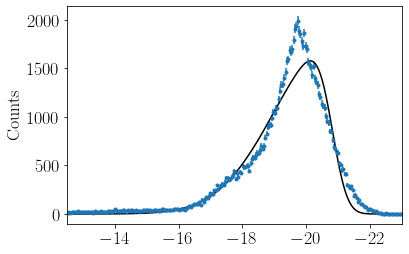

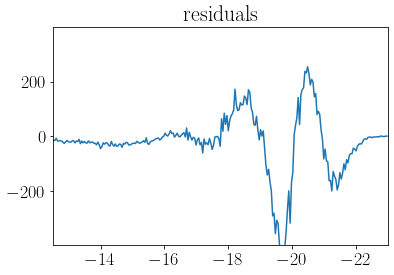

(array([3952.88775721,  -20.81385544,    1.79619957,    4.78376728]),
 array([63.27895184,  0.02041079,  0.0278884 ,  0.14304972]))

In [224]:
fit_unimodal(char_=rabsmag,class_=wall_v2,bins=np.linspace(-23,-12.5, 250), err=poiss_err,p0_=[ 2000,  -20,  1.3, 1])


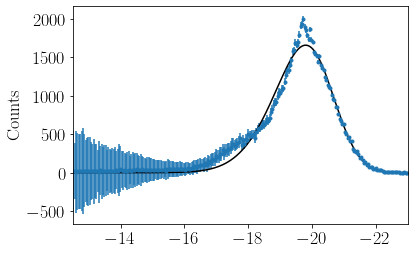

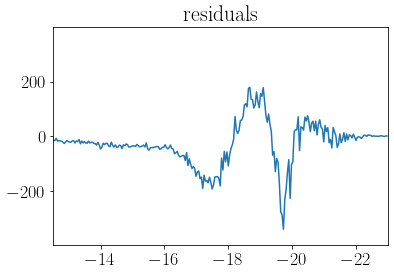

(array([3907.01886042,  -20.52329976,    1.32736636,    1.66325177]),
 array([65.64855555,  0.02568051,  0.04768439,  0.10251107]))

In [223]:
fit_unimodal(char_=rabsmag,class_=wall_v2,bins=np.linspace(-23,-12.5, 250), err=bin_errors[:-1]*5000,p0_=[ 2000,  -20,  1.3, 1])


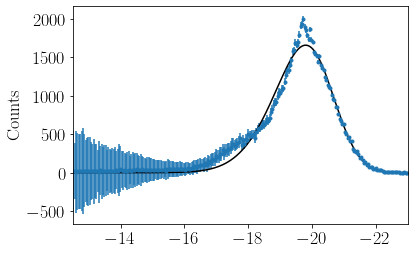

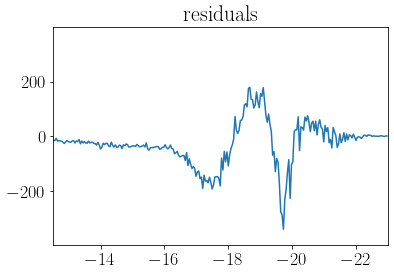

(array([3907.01886042,  -20.52329976,    1.32736636,    1.66325177]),
 array([65.64855555,  0.02568051,  0.04768439,  0.10251107]))

In [203]:
fit_unimodal(char_=rabsmag,class_=wall_v2,bins=np.linspace(-23,-12.5, 250), err=bin_errors[:-1]*5000,p0_=[ 2000,  -20,  1.3, 1])


In [ ]:
(array([3919.63107647,  -20.52417618,    1.34032485,    1.65759719]),
 array([617.93700747,   0.18422483,   0.4006407 ,   0.78174444]))

 #### Previously

In [212]:
# Mstar : x_data,y_data,dy=bin_data(data=Mstar[void_vf],bins_=np.linspace(5.9,12, 135)) p0=[ 3.91918777e+03,  1.08277243e+01,  9.17679137e-01, -3.31852784e+00]
x_data,y_data,dy=bin_data(data=rabsmag[wall_v2],bins_=np.linspace(5.9,12, 135))

In [213]:
dy[np.argwhere(dy==0)]= 0.000001

In [214]:
systematic = dy[np.argwhere(np.logical_and(x_data>8.5,x_data<9.5)==True)]
dy[np.argwhere(np.logical_and(x_data>8.5,x_data<9.5)==True)]+=systematic  # doubles the errors in the bump

In [215]:
test=np.zeros((len(dy),len(dy)))
cov = np.fill_diagonal(test,dy)

In [216]:
#void_vf: popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,sigma=test,p0=[ 3.91918777e+03,  1.08277243e+01,  9.17679137e-01, -3.31852784e+00])
# 10.8523 7.25856613e-03
popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,sigma=test,p0=[ 3.91918777e+03,  10,  9.17679137e-01, -3.31852784e+00])#wall_vf popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,sigma=test,p0=[ 3.91918777e+03,  1.08277243e+01,  9.17679137e-01, -3.31852784e+00])
# popt_, pcov_ = curve_fit(func_unimodal, x_data, y_data,sigma=test,p0=[ 3.91918777e+03,  10,  9.17679137e-01, -3.31852784e+00])
# 10.941221 6.02014390e-03



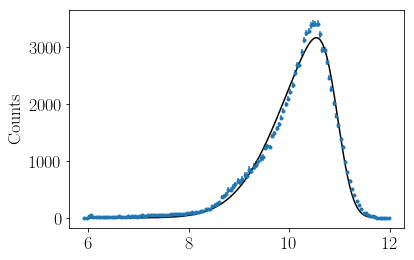

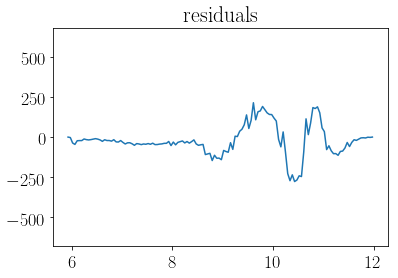

In [217]:
plt.errorbar(x_data, y_data, yerr=dy, fmt='.')  
# plt.plot(x, func_bimodal1(x, *popt_void[:4]), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
# plt.plot(x, func_bimodal1(x, *popt_void[4:]), 'g-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
plt.plot(x_data, func_unimodal(x_data, *popt_), 'black') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))

# plt.title(label + " Void")
# plt.xlabel(label)
plt.ylabel("Counts")
plt.show()


plt.plot(x_data,func_unimodal(x_data, *popt_)-y_data)
plt.ylim(-np.max(y_data)/5,np.max(y_data)/5)
plt.title('residuals')
plt.show()

In [218]:
popt_,np.sqrt(np.diag(pcov_))

(array([ 4.51584149e+03,  1.09534817e+01,  9.95643263e-01, -4.01458643e+00]),
 array([4.16373557e+01, 7.23131054e-03, 1.31684166e-02, 1.21729240e-01]))

In [206]:
popt_

array([ 8.90790295e+03,  1.09080835e+01,  8.49088696e-01, -2.83398450e+00])

In [205]:
np.sqrt(np.diag(pcov_))

array([5.32807244e+01, 5.95005474e-03, 9.07580442e-03, 8.74514794e-02])

In [160]:
#include sigma=test [popt_,np.sqrt(np.diag(pcov_))]
Mstar_fit_wall_vf=[np.array([ 7.80592986e+03,  1.09412215e+01,  8.66478001e-01, -2.96531793e+00]),np.array([4.82058569e+01, 6.02014390e-03, 8.20260857e-03, 9.24132759e-02])]
Mstar_fit_void_vf=[np.array([ 3.93190226e+03,  1.08523401e+01,  9.78871065e-01, -4.43249920e+00]),np.array([3.71872153e+01, 7.25856613e-03, 1.19457928e-02, 1.21169041e-01])]


In [176]:
10.94-10.85

0.08999999999999986

In [177]:
10.957- 10.91

0.0470000000000006

### extract the mean and the error in the mean from the fit results

### Calculate averages and medians

In [17]:
def remove_nan(array):
    return array[np.logical_not(np.isnan(array))]

In [14]:
def stats(char_,voidfinder =False):
    '''
    char : array with galaxy properties e.g : Mstar
    voidfinder : true if we want to calculate the statistics of voidfinder data and not V^2 data
    
    note 1 : shifts are taken as void-wall
    note 2: percent difference are calculated with respect to the wall distribution
    
    returns: average, std of average, average shift, std of average shift, percent diff of avg , median, median shift, 
    percent diff of median
    '''
    if voidfinder==True:
        char_void= remove_nan(char_[void_vf])
        char_wall=remove_nan(char_[wall_vf])
        
    else:
        char_void= remove_nan(char_[void_v2])
        char_wall=remove_nan(char_[wall_v2])
        
    avg_void = np.mean(char_void)
    avg_wall = np.mean(char_wall)
        
    avg_shift=  avg_wall-avg_void
        
    std_avg_void = np.std(char_void,ddof=1)/np.sqrt(len(char_void))
    std_avg_wall = np.std(char_wall,ddof=1)/np.sqrt(len(char_wall))
    
    std_avg_shift = np.sqrt(std_avg_void**2 + std_avg_wall**2)
        
    percent_diff_avg = (avg_shift/avg_wall)*100
    
    median_wall = np.median(char_wall)
    median_void = np.median(char_void)
    
    median_shift = median_wall-median_void
    
    percent_diff_median = (median_shift/median_wall)*100
    
    print('average void : %f +- %f' %(avg_void, std_avg_void))
    print('average wall :  %f +- %f'%(avg_wall, std_avg_wall))
    print('average shift w.r.t wall :  %f +- %f'%(avg_shift, std_avg_shift))
    print('percent difference in avg w.r.t wall : ', percent_diff_avg)
    print('median void : ', median_void)
    print('median wall : ', median_wall)
    print('median shift w.r.t wall: ', median_shift)
    print('percent difference in median w.r.t wall : ', percent_diff_median)


In [25]:
stats(sSFR, voidfinder=True)


average void : -10.451034 +- 0.003962
average wall :  -10.724633 +- 0.001909
average shift w.r.t wall :  -0.273599 +- 0.004398
percent difference in avg w.r.t wall :  2.5511244529926858
median void :  -10.201032638549805
median wall :  -10.563491821289062
median shift w.r.t wall:  -0.3624591827392578
percent difference in median w.r.t wall :  3.4312440324777658


In [27]:
stats(sSFR)

average void : -10.702911 +- 0.001973
average wall :  -10.652602 +- 0.002572
average shift w.r.t wall :  0.050309 +- 0.003242
percent difference in avg w.r.t wall :  -0.4722709265591281
median void :  -10.517784595489502
median wall :  -10.457787990570068
median shift w.r.t wall:  0.059996604919433594
percent difference in median w.r.t wall :  -0.5737026316992978


In [832]:
stats(sSFR, voidfinder=True)


average void : -10.451034 +- 0.003962
average wall :  -10.724633 +- 0.001909
average shift w.r.t wall :  -0.273599 +- 0.004398
percent difference in avg w.r.t wall :  2.5511244529926858
median void :  -10.201032638549805
median wall :  -10.563491821289062
median shift w.r.t wall:  -0.3624591827392578
percent difference in median w.r.t wall :  3.4312440324777658


In [829]:
stats(SFR)

average void : -0.384173 +- 0.001510
average wall :  -0.509991 +- 0.002095
average shift w.r.t wall :  -0.125818 +- 0.002583
percent difference in avg w.r.t wall :  24.6706388562237
median void :  -0.324832558631897
median wall :  -0.4944124221801758
median shift w.r.t wall:  -0.1695798635482788
percent difference in median w.r.t wall :  34.29927241724518


In [724]:
from pprint import pprint
pprint ([(i, stats.ks_2samp(Mstar[void_vf][:i], Mstar[void_v2][:i])[1]) for i in range(28030,28050,1)])

[(28030, 1e-323),
 (28031, 1e-323),
 (28032, 1e-323),
 (28033, 1e-323),
 (28034, 1e-323),
 (28035, 1e-323),
 (28036, 0.0),
 (28037, 0.0),
 (28038, 0.0),
 (28039, 0.0),
 (28040, 0.0),
 (28041, 0.0),
 (28042, 0.0),
 (28043, 0.0),
 (28044, 0.0),
 (28045, 0.0),
 (28046, 0.0),
 (28047, 0.0),
 (28048, 0.0),
 (28049, 0.0)]


In [731]:
print(len(remove_nan(Mstar)[(remove_nan(Mstar)>10)]))

542611


In [735]:
stats.ks_2samp(Mstar[wall_v2][Mstar[wall_v2]<10], Mstar[void_v2][Mstar[void_v2]<10]) #V^2

Ks_2sampResult(statistic=0.08318112786478526, pvalue=0.0)

In [52]:
from scipy.stats import norm
sigma = norm.isf(10**(-200))

In [53]:
sigma

30.20559417957964